# Simulate stochastic process

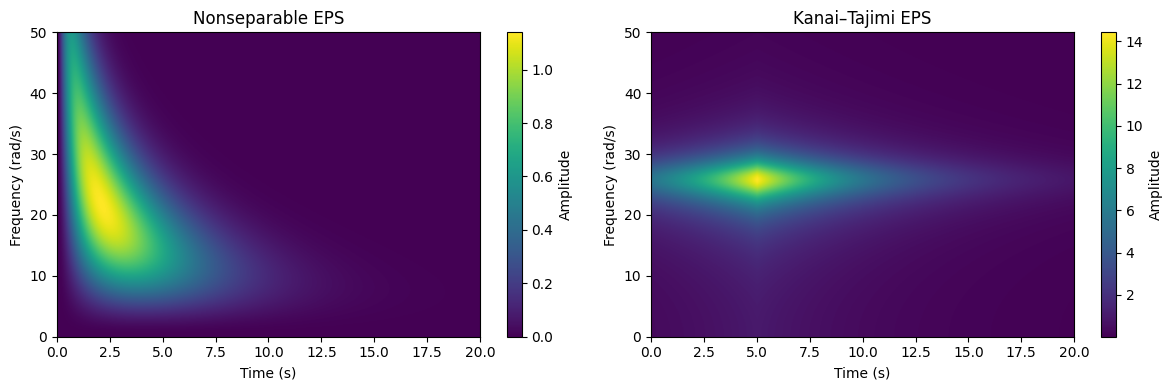

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from eps.nonsep import nonseparable_evolutionary_power_spectrum
from eps.kt import kt_evolutionary_power_spectrum

time = np.linspace(0, 20, 512)
freq = np.linspace(0, 50, 512)

X, Y = np.meshgrid(time, freq)

eps_cp = np.zeros((len(time), len(freq)))
eps_kt = np.zeros((len(time), len(freq)))

#EPSs parameters
S0 = 1
b0 = 0.47500000000000003

#KT parameter
omega_g = 26.25
zeta_g = 0.1375

for i in range(len(time)):
    for j in range(len(freq)):
        eps_cp[i][j] = nonseparable_evolutionary_power_spectrum(freq[j], time[i], S0, b0)
        eps_kt[i][j] = kt_evolutionary_power_spectrum(freq[j], time[i], S0, omega_g, zeta_g, b0, 5)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

im0 = axes[0].imshow(
    eps_cp.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[0].set_title("Nonseparable EPS")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Frequency (rad/s)")
fig.colorbar(im0, ax=axes[0], label="Amplitude")

im1 = axes[1].imshow(
    eps_kt.T,                  # transpose so freq is y-axis
    extent=[time.min(), time.max(), freq.min(), freq.max()],
    origin='lower',
    aspect='auto',
    cmap=cm.viridis
)
axes[1].set_title("Kanai–Tajimi EPS")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (rad/s)")
fig.colorbar(im1, ax=axes[1], label="Amplitude")

plt.tight_layout()
plt.show()

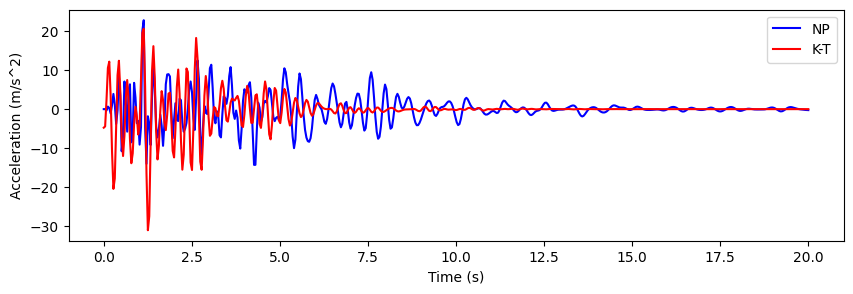

In [80]:
from simulate_process import simulate_process
import pandas as pd

w_cp = np.zeros((200, len(time)))
w_kt = np.zeros((200, len(time)))

for i in range(w_cp.shape[0]):
    w_cp[i,:] = simulate_process(time, S0, max(freq), omega_g, zeta_g, b0)
    w_kt[i,:] = simulate_process(time, S0, omega_g, omega_g, zeta_g, b0, eps_type='kt')

fig = plt.figure(figsize=(10,3))

plt.plot(time, w_cp[10,:], 'b')
plt.plot(time, w_kt[10,:], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend(['NP', 'K-T'])
plt.show()

w_cp_df = pd.DataFrame(w_cp.T).add_prefix('cp_')
w_kt_df = pd.DataFrame(w_kt.T).add_prefix('kt_')

df_results = pd.concat([w_cp_df, w_kt_df], axis=1)
df_results['time'] = time
df_results.to_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv', index=False)

# GHW

In [3]:
import numpy as np
import pandas as pd
from wavelet.get_band_options import ghw_band_options

#df = pd.read_csv(f'data/realizations/stochastic_process_{S0}_{b0}_{omega_g}_{zeta_g}.csv')
df = pd.read_csv(f'data/realizations/stochastic_process_0.5_0.4_38.75_0.25_freq_cp_50.0_freq_kt_38.75.csv')

t = df["time"].values
x = df["cp_1"].values

dt = np.diff(t)
fs = 1.0 / np.median(dt)
print(f"Estimated fs = {fs:.2f} Hz")
print(f"Max dt = {max(dt):.4f} s")

# bands
bins_per_band = 4
uniform_bands, adaptive_bands, freqs = ghw_band_options(x, fs, bins_per_band=bins_per_band, spike_prominence=1e-1)

Estimated fs = 25.55 Hz
Max dt = 0.0391 s


In [4]:
from wavelet.ghw_transform import ghw_transform

# Apply GHW
out_uniform = ghw_transform(x, fs, uniform_bands, analytic=True, return_downsampled=False)
out_adaptive = ghw_transform(x, fs, adaptive_bands, analytic=True, return_downsampled=False)

# Extract coefficients and bands from ghw_transform output
coeffs = out_uniform["complex"]    # list of arrays per band
bands = out_uniform["bands"]       # (flo, fhi) Hz

num_bands = len(coeffs)

In [7]:
np.array(coeffs).shape

(65, 512)

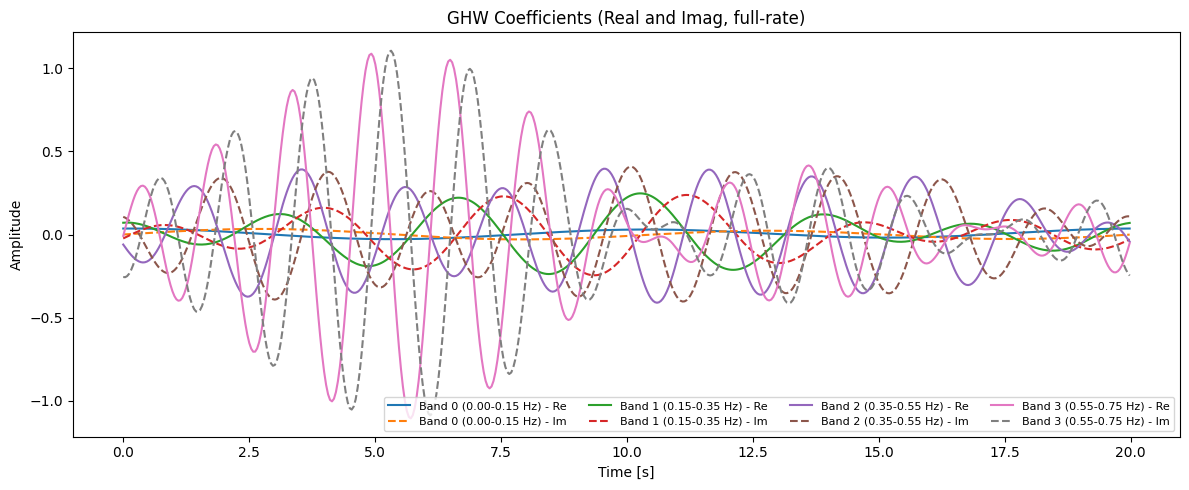

In [83]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 40, 1024)
dt = time[1] - time[0]
t_original = np.arange(len(x)) * dt

plt.figure(figsize=(12,5))
n_bands_to_plot = 4 

for i in range(min(n_bands_to_plot, len(coeffs))):
    c = coeffs[i]
    plt.plot(t_original, c.real, label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Re")
    plt.plot(t_original, c.imag, "--", label=f"Band {i} ({bands[i,0]:.2f}-{bands[i,1]:.2f} Hz) - Im")

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("GHW Coefficients (Real and Imag, full-rate)")
plt.legend(fontsize=8, ncol=n_bands_to_plot)
plt.tight_layout()
plt.show()

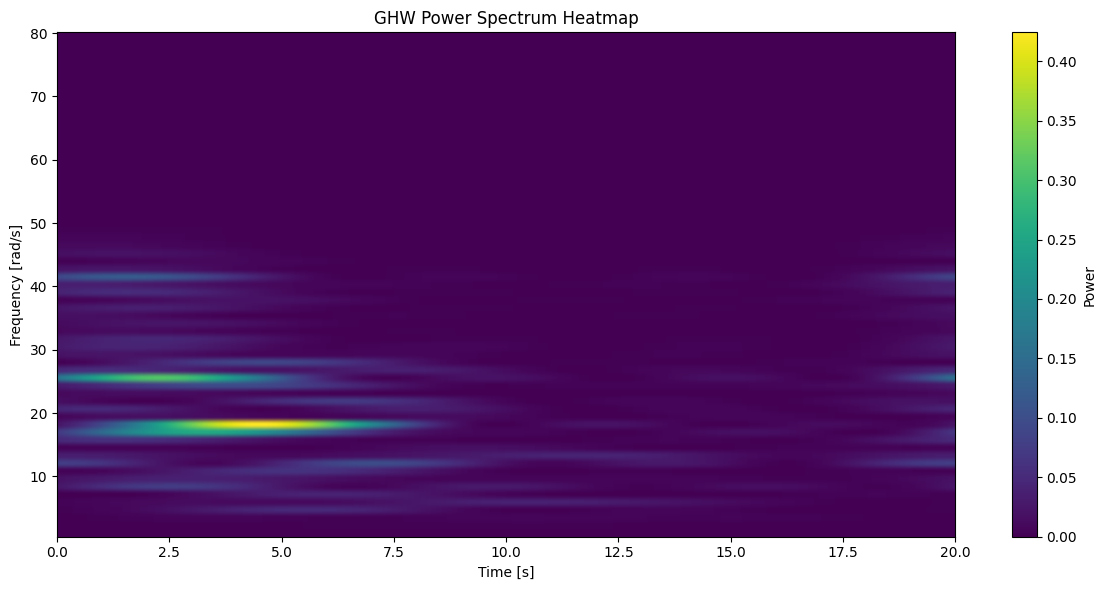

In [84]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0,20,512)
power_matrix = np.array([np.abs(c)**2/(2*np.pi*4) for c in coeffs])
freq_centers = 2*np.pi*np.array([(b[0]+b[1])/2 for b in bands])

plt.figure(figsize=(12,6))
plt.imshow(power_matrix, aspect='auto', origin='lower',
           extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]])
plt.colorbar(label='Power')
plt.xlabel("Time [s]")
plt.ylabel("Frequency [rad/s]")
plt.title("GHW Power Spectrum Heatmap")
plt.tight_layout()
plt.show()

In [67]:
x_rec = out_uniform["reconstruct_fullrate"]()

# Scale to match original signal RMS
scale = np.std(x) / np.std(x_rec)
x_rec_scaled = x_rec * scale

plt.figure(figsize=(12,4))
plt.plot(time, x, label="Original")
plt.plot(time, x_rec_scaled, label="Reconstructed (scaled)", alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Original vs Reconstructed Signal")
plt.legend()
plt.tight_layout()
plt.show()


# Get coef

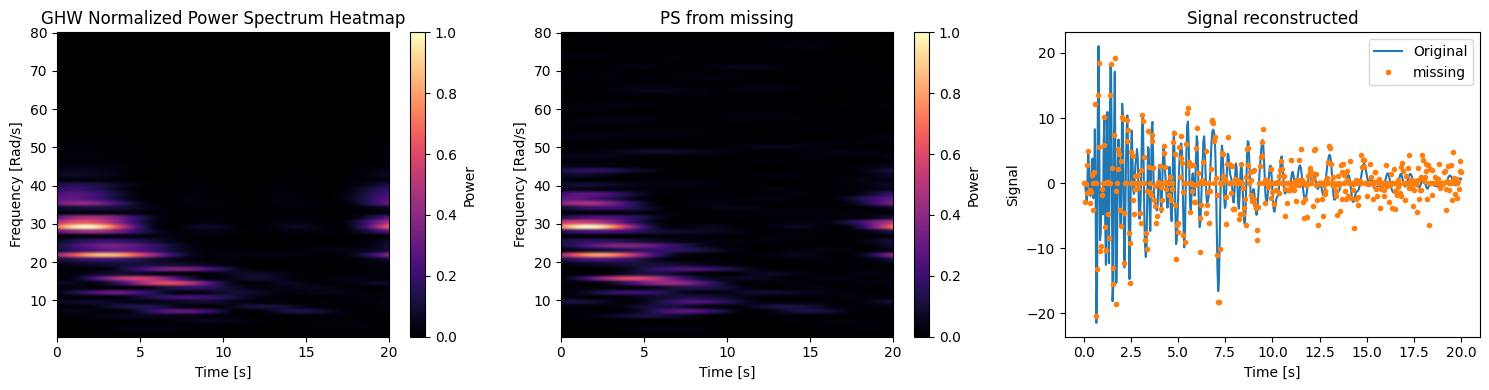

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_power(df: pd.DataFrame, df_aux = None, tmax: float = 20, timesteps: int = 512, width = 4, df_type = None): 
    time = np.linspace(0, tmax, timesteps)
    freq_centers = 2*np.pi*df['freq_centers'].values
    coeffs = df.drop(columns='freq_centers')
    power_matrix = np.array([np.abs(c)**2/(2*np.pi*width) for c in coeffs.values])
    normalized_power_matrix = (power_matrix - power_matrix.min()) / (power_matrix.max() - power_matrix.min())

    if df_aux is not None:
        coeffs_aux = df_aux.drop(columns='freq_centers')
        power_matrix_aux = np.array([np.abs(coeffs_aux)**2/(2*np.pi*width) for coeffs_aux in coeffs_aux.values])
        normalized_power_matrix_aux = (power_matrix_aux - power_matrix_aux.min()) / (power_matrix_aux.max() - power_matrix_aux.min())

    if df_aux is None:
        fig = plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(normalized_power_matrix, aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title("GHW Normalized Power Spectrum Heatmap")

        plt.subplot(1,2,2)
        reconstructed_signal = np.sum(coeffs.values.real, axis=0)
        plt.plot(time, reconstructed_signal)
        plt.xlabel("Time [s]")
        plt.ylabel("Signal")
        plt.title("Signal reconstructed")

    else:
        fig = plt.figure(figsize=(15,4))
        plt.subplot(1,3,1)
        plt.imshow(normalized_power_matrix, aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title("GHW Normalized Power Spectrum Heatmap")

        plt.subplot(1,3,2)
        plt.imshow(np.abs(normalized_power_matrix_aux), aspect='auto', origin='lower', extent=[time[0], time[-1], freq_centers[0], freq_centers[-1]], cmap='magma')
        plt.colorbar(label='Power')
        plt.xlabel("Time [s]")
        plt.ylabel("Frequency [Rad/s]")
        plt.title(f"PS from {df_type}")

        plt.subplot(1,3,3)
        reconstructed_signal = np.sum(coeffs.values.real, axis=0)
        reconstructed_signal_aux = np.sum(coeffs_aux.values.real, axis=0)
        plt.plot(time, reconstructed_signal)
        plt.plot(time, reconstructed_signal_aux, '.')
        plt.legend(['Original', f'{df_type}'])
        plt.xlabel("Time [s]")
        plt.ylabel("Signal")
        plt.title("Signal reconstructed")

    plt.tight_layout()
    plt.show()

import os

directory_path = 'data/transformations/'

all_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                if os.path.isfile(os.path.join(directory_path, f))]

all_files = [f for f in all_files if 'noisy' not in f and 'missing' not in f]

filename = all_files[200]
df : pd.DataFrame = pd.read_pickle(filename)
#df_noisy : pd.DataFrame = pd.read_pickle(f'{filename.split('.pkl')[0]}_noisy.pkl')
df_missing: pd.DataFrame = pd.read_pickle(f'{filename.split('.pkl')[0]}_missing.pkl')

#df_nm = pd.DataFrame(df_noisy.drop(columns='freq_centers').values * df_missing.drop(columns='freq_centers').values)
#df_nm['freq_centers'] = df_noisy['freq_centers']

#plot_power(df, df_noisy, df_type='noise')
plot_power(df, df_missing, df_type='missing')
#plot_power(df, df_nm, df_type='noise')

# Data Prep

In [2]:
import os
import re
import numpy as np
import pandas as pd
import torch

from typing import Optional
from joblib import Parallel, delayed
from tqdm import tqdm
from torch_geometric.data import Data, InMemoryDataset

import numpy as np

def _features_mag_cossin(C: np.ndarray) -> np.ndarray:
    """
    Returns node features: [real, imag].
    """
    real = np.real(C)
    denom = real.max() - real.min()
    real = np.zeros_like(real, dtype=float) if denom == 0 else (real - real.min()) / denom

    imag = np.imag(C)
    denom = imag.max() - imag.min()
    imag = np.zeros_like(imag, dtype=float) if denom == 0 else (imag - imag.min()) / denom

    return np.stack([real, imag], axis=-1)  # (H, W, 2)

def grid_edge_index(height: int, width: int, add_diagonals: bool = False) -> torch.Tensor:
    edges = []
    def idx(i, j): return i * width + j
    for i in range(height):
        for j in range(width):
            u = idx(i, j)
            if j + 1 < width:  edges.append((u, idx(i, j + 1)))
            if j - 1 >= 0:     edges.append((u, idx(i, j - 1)))
            if i + 1 < height: edges.append((u, idx(i + 1, j)))
            if i - 1 >= 0:     edges.append((u, idx(i - 1, j)))
            if add_diagonals:
                if i + 1 < height and j + 1 < width: edges.append((u, idx(i + 1, j + 1)))
                if i + 1 < height and j - 1 >= 0:    edges.append((u, idx(i + 1, j - 1)))
                if i - 1 >= 0 and j + 1 < width:     edges.append((u, idx(i - 1, j + 1)))
                if i - 1 >= 0 and j - 1 >= 0:        edges.append((u, idx(i - 1, j - 1)))
    return torch.tensor(edges, dtype=torch.long).t().contiguous()  # [2, E]

def process_one_file(
    clean_path: str,
    height: int,
    width: int,
    edge_index: torch.Tensor,
    graphs_out_dir: str = "data/graphs",
) -> Optional[Data]:
    """
    For a clean file '..._cp_{id}.pkl', we expect siblings:
      ..._cp_{id}_noisy.pkl and ..._cp_{id}_missing.pkl
    """
    base_no_ext = os.path.splitext(clean_path)[0]
    miss_path   = f"{base_no_ext}_missing.pkl"

    df_clean   = pd.read_pickle(clean_path)
    df_missing = pd.read_pickle(miss_path)

    # Drop helper column if present and last row (to match original layout)
    def _coeffs(df: pd.DataFrame) -> np.ndarray:
        if "freq_centers" in df.columns:
            df = df.drop(columns="freq_centers")
        return df.iloc[:-1, :].values

    C_clean = _coeffs(df_clean)
    C_miss  = _coeffs(df_missing)

    if C_clean.shape != (height, width):
        return None

    # ----- real & imag features (2 channels) -----
    F_clean = _features_mag_cossin(C_clean)  # (H, W, 2)
    F_corr  = _features_mag_cossin(C_miss)   # (H, W, 2)

    # Flatten to (N, 2)
    N = height * width
    x = torch.from_numpy(F_corr.reshape(N, 2)).float().contiguous()
    y = torch.from_numpy(F_clean.reshape(N, 2)).float().contiguous()

    graph = Data(
        x=x, y=y, edge_index=edge_index,
        height=height, width=width,
        file=os.path.basename(clean_path),
    )

    # Save one .pt per graph
    os.makedirs(graphs_out_dir, exist_ok=True)
    out_name = os.path.join(graphs_out_dir, f"{os.path.basename(clean_path)}.pt")
    torch.save(graph, out_name)
    return graph

class GHWGraphTFDatasetParallel(InMemoryDataset):
    """
    Parallel data preparation with joblib.

    Node features: [|C|, phase_01].
    x = features from corrupted (noisy * missing)
    y = features from clean
    Only processes clean files matching '*_cp_{id}.pkl'.
    """

    _cp_regex = re.compile(r"_cp_[^/\\]+\.pkl$")  # flexible {id}; e.g., _cp_42.pkl or _cp_00042.pkl

    def __init__(self, root_dir: str, height: int = 64, width: int = 512, add_diagonals: bool = False, n_jobs: int = -1, show_progress: bool = True,
        file_limit: int = None, graphs_out_dir: str = "data/graphs", transform=None, pre_transform=None,
    ):
        self.height = height
        self.width = width
        self.add_diagonals = add_diagonals
        self.graphs_out_dir = graphs_out_dir
        super().__init__(root=root_dir, transform=transform, pre_transform=pre_transform)

        # Gather clean files: match "*_cp_{id}.pkl" but exclude *_noisy/_missing
        all_files = [
            os.path.join(root_dir, f) for f in os.listdir(root_dir)
            if os.path.isfile(os.path.join(root_dir, f))
        ]
        clean_files = [
            f for f in all_files
            if f.endswith(".pkl")
            and "_noisy" not in f
            and "_missing" not in f
            and self._cp_regex.search(os.path.basename(f)) is not None
        ]
        clean_files.sort()
        if file_limit is not None:
            clean_files = clean_files[:file_limit]
        self.clean_files = clean_files

        edge_index = grid_edge_index(self.height, self.width, self.add_diagonals)

        # Parallel processing
        iterator = clean_files
        if show_progress:
            iterator = tqdm(clean_files, desc="Building graphs (|C| & phase)")

        _ = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(process_one_file)(
                path, self.height, self.width, edge_index, self.graphs_out_dir
            )
            for path in iterator
        )

# -------------------------------
# Example use
# -------------------------------
root = "data/transformations/"
ds = GHWGraphTFDatasetParallel(
    root_dir=root, height=64, width=512,
    add_diagonals=False,
    n_jobs=-1,
    show_progress=True,
    file_limit=5000,
    graphs_out_dir="data/graphs",
)

Building graphs (|C| & phase): 100%|██████████| 5000/5000 [00:35<00:00, 142.68it/s]


In [3]:
import os
import torch
from torch.utils.data import Dataset, random_split
from torch_geometric.loader import DataLoader

class GraphDataset(Dataset):
    def __init__(self, folder_path):
        self.files = sorted(
            [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".pt")]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return torch.load(self.files[idx], weights_only=False)  # returns a torch_geometric.data.Data

dataset = GraphDataset("data/graphs/")

# Train/Val splits only
n_total = len(dataset)
n_train = int(0.9 * n_total)
n_val   = n_total - n_train

train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))
print(len(train_ds), len(val_ds))

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)

4500 500


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GraphUNet
from tqdm import tqdm

import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    """
    Simple GCN stack for node-level tasks.
    - num_layers = depth
    - hidden_channels is an int (same at each layer)
    """
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int,
                 num_layers: int = 3, dropout: float = 0.2):
        super().__init__()
        assert num_layers >= 2, "Use at least 2 layers (input->hidden, hidden->output)."

        self.convs = nn.ModuleList()
        self.bns   = nn.ModuleList()
        self.dropout = dropout

        # Input layer
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=False, normalize=True))
        self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels, cached=False, normalize=True))
            self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Output layer
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=False, normalize=True))

    def forward(self, x, edge_index, edge_weight=None):
        # All but last layer: conv -> BN -> ReLU -> Dropout
        for conv, bn in zip(self.convs[:-1], self.bns):
            x = conv(x, edge_index, edge_weight=edge_weight)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        # Last layer (no activation for regression)
        x = self.convs[-1](x, edge_index, edge_weight=edge_weight)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

max_epochs     = 40
base_lr        = 1e-3
weight_decay   = 1e-4

sample = next(iter(train_loader))
in_channels  = sample.x.size(-1)
out_channels = sample.y.size(-1)
print(sample)
del sample

hidden_channels = 256
depth           = 4
pool_ratios     = 0.5

# model = GraphUNet(
#     in_channels=in_channels,
#     hidden_channels=hidden_channels,
#     out_channels=out_channels,
#     depth=depth,
#     pool_ratios=pool_ratios
# ).to(device)

model = GCN(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=depth,
    dropout=0.3
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)

def mag_phase_loss(
    pred: torch.Tensor,  # (N, 3) -> [mag, cos, sin]
    target: torch.Tensor, # (N, 3)
    phase_weight: float = 1.0,
    mag_weight: float = 1.0,
    phase_mag_weighting: bool = True,  # weight phase loss by target magnitude
    eps: float = 1e-8
):
    r_p, i_p, = pred[:, 0:1], pred[:, 1:2]
    r_t, i_t, = target[:, 0:1], target[:, 1:2]

    L_real = F.mse_loss(r_p, r_t)
    L_imag = F.mse_loss(i_p, i_t)

    return mag_weight * L_real + phase_weight * L_imag, {"L_mag": L_real.item(), "L_phase": L_imag.item()}

def train_one_epoch(epoch):
    model.train()
    total_loss, n_nodes = 0.0, 0

    for batch in tqdm(train_loader):
        batch = batch.to(device, non_blocking=True)

        optimizer.zero_grad()
        pred = model(batch.x, batch.edge_index)
        loss, parts = mag_phase_loss(pred, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.x.size(0)
        n_nodes    += batch.x.size(0)

    return total_loss / max(1, n_nodes)

@torch.no_grad()
def validate():
    model.eval()
    total_loss, n_nodes = 0.0, 0
    for batch in tqdm(val_loader):
        batch = batch.to(device, non_blocking=True)
        pred = model(batch.x, batch.edge_index)
        loss, parts = mag_phase_loss(pred, batch.y)
        total_loss += loss.item() * batch.x.size(0)
        n_nodes    += batch.x.size(0)
    return total_loss / max(1, n_nodes)

best_val = float("inf")
for epoch in range(max_epochs):
    train_loss = train_one_epoch(epoch)
    val_loss   = validate()

    #scheduler.step()

    if val_loss < best_val and torch.isfinite(torch.tensor(val_loss)):
        best_val = val_loss
        torch.save(model.state_dict(), 'graphunet.pt')  # save weights (safer than pickling module)

    print(
        f"Epoch {epoch:03d} | "
        f"lr={base_lr} | "
        f"train={train_loss:.6f} | val={val_loss:.6f} | best={best_val:.6f}"
    )

cuda
DataBatch(x=[131072, 2], edge_index=[2, 519680], y=[131072, 2], height=[4], width=[4], file=[4], batch=[131072], ptr=[5])


100%|██████████| 125/125 [00:15<00:00,  7.98it/s]


Epoch 000 | lr=0.001 | train=0.058127 | val=0.013892 | best=0.013892


100%|██████████| 125/125 [00:10<00:00, 12.26it/s]


Epoch 001 | lr=0.001 | train=0.010705 | val=0.008985 | best=0.008985


100%|██████████| 125/125 [00:09<00:00, 13.41it/s]


Epoch 002 | lr=0.001 | train=0.008400 | val=0.007977 | best=0.007977


100%|██████████| 125/125 [00:09<00:00, 13.42it/s]


Epoch 003 | lr=0.001 | train=0.007789 | val=0.007578 | best=0.007578


100%|██████████| 125/125 [00:09<00:00, 13.50it/s]


Epoch 004 | lr=0.001 | train=0.007538 | val=0.007407 | best=0.007407


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 005 | lr=0.001 | train=0.007401 | val=0.007324 | best=0.007324


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 006 | lr=0.001 | train=0.007303 | val=0.007224 | best=0.007224


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 007 | lr=0.001 | train=0.007197 | val=0.007187 | best=0.007187


100%|██████████| 125/125 [00:09<00:00, 13.45it/s]


Epoch 008 | lr=0.001 | train=0.007078 | val=0.006995 | best=0.006995


100%|██████████| 125/125 [00:09<00:00, 13.44it/s]


Epoch 009 | lr=0.001 | train=0.006975 | val=0.006911 | best=0.006911


100%|██████████| 125/125 [00:09<00:00, 13.46it/s]


Epoch 010 | lr=0.001 | train=0.006867 | val=0.006833 | best=0.006833


100%|██████████| 125/125 [00:09<00:00, 13.48it/s]


Epoch 011 | lr=0.001 | train=0.006750 | val=0.006788 | best=0.006788


100%|██████████| 125/125 [00:09<00:00, 13.49it/s]


Epoch 012 | lr=0.001 | train=0.006637 | val=0.006721 | best=0.006721


100%|██████████| 125/125 [00:09<00:00, 13.48it/s]


Epoch 013 | lr=0.001 | train=0.006549 | val=0.006552 | best=0.006552


100%|██████████| 125/125 [00:09<00:00, 13.46it/s]


Epoch 014 | lr=0.001 | train=0.006457 | val=0.006472 | best=0.006472


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 015 | lr=0.001 | train=0.006386 | val=0.006432 | best=0.006432


100%|██████████| 125/125 [00:09<00:00, 13.48it/s]


Epoch 016 | lr=0.001 | train=0.006311 | val=0.006283 | best=0.006283


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 017 | lr=0.001 | train=0.006263 | val=0.006227 | best=0.006227


100%|██████████| 125/125 [00:09<00:00, 13.48it/s]


Epoch 018 | lr=0.001 | train=0.006208 | val=0.006153 | best=0.006153


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 019 | lr=0.001 | train=0.006163 | val=0.006157 | best=0.006153


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 020 | lr=0.001 | train=0.006110 | val=0.006177 | best=0.006153


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 021 | lr=0.001 | train=0.006083 | val=0.006013 | best=0.006013


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 022 | lr=0.001 | train=0.006051 | val=0.006108 | best=0.006013


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 023 | lr=0.001 | train=0.006016 | val=0.006113 | best=0.006013


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 024 | lr=0.001 | train=0.006000 | val=0.006006 | best=0.006006


100%|██████████| 125/125 [00:09<00:00, 13.48it/s]


Epoch 025 | lr=0.001 | train=0.005981 | val=0.006268 | best=0.006006


100%|██████████| 125/125 [00:09<00:00, 13.46it/s]


Epoch 026 | lr=0.001 | train=0.005958 | val=0.005988 | best=0.005988


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 027 | lr=0.001 | train=0.005942 | val=0.005983 | best=0.005983


100%|██████████| 125/125 [00:09<00:00, 13.48it/s]


Epoch 028 | lr=0.001 | train=0.005920 | val=0.005897 | best=0.005897


100%|██████████| 125/125 [00:09<00:00, 13.46it/s]


Epoch 029 | lr=0.001 | train=0.005909 | val=0.006058 | best=0.005897


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 030 | lr=0.001 | train=0.005895 | val=0.005929 | best=0.005897


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 031 | lr=0.001 | train=0.005880 | val=0.005886 | best=0.005886


100%|██████████| 125/125 [00:09<00:00, 13.47it/s]


Epoch 032 | lr=0.001 | train=0.005880 | val=0.005952 | best=0.005886


100%|██████████| 125/125 [00:09<00:00, 13.43it/s]


Epoch 033 | lr=0.001 | train=0.005862 | val=0.005901 | best=0.005886


100%|██████████| 125/125 [00:09<00:00, 13.46it/s]


Epoch 034 | lr=0.001 | train=0.005852 | val=0.005917 | best=0.005886


100%|██████████| 125/125 [00:09<00:00, 13.48it/s]


Epoch 035 | lr=0.001 | train=0.005835 | val=0.006267 | best=0.005886


100%|██████████| 125/125 [00:09<00:00, 13.32it/s]


Epoch 036 | lr=0.001 | train=0.005834 | val=0.005836 | best=0.005836


100%|██████████| 125/125 [00:09<00:00, 13.43it/s]


Epoch 037 | lr=0.001 | train=0.005826 | val=0.006067 | best=0.005836


100%|██████████| 125/125 [00:09<00:00, 13.42it/s]


Epoch 038 | lr=0.001 | train=0.005817 | val=0.005859 | best=0.005836


100%|██████████| 125/125 [00:09<00:00, 13.39it/s]

Epoch 039 | lr=0.001 | train=0.005817 | val=0.005886 | best=0.005836


: 

DataBatch(x=[131072, 2], edge_index=[2, 519680], y=[131072, 2], height=[4], width=[4], file=[4], batch=[131072], ptr=[5])


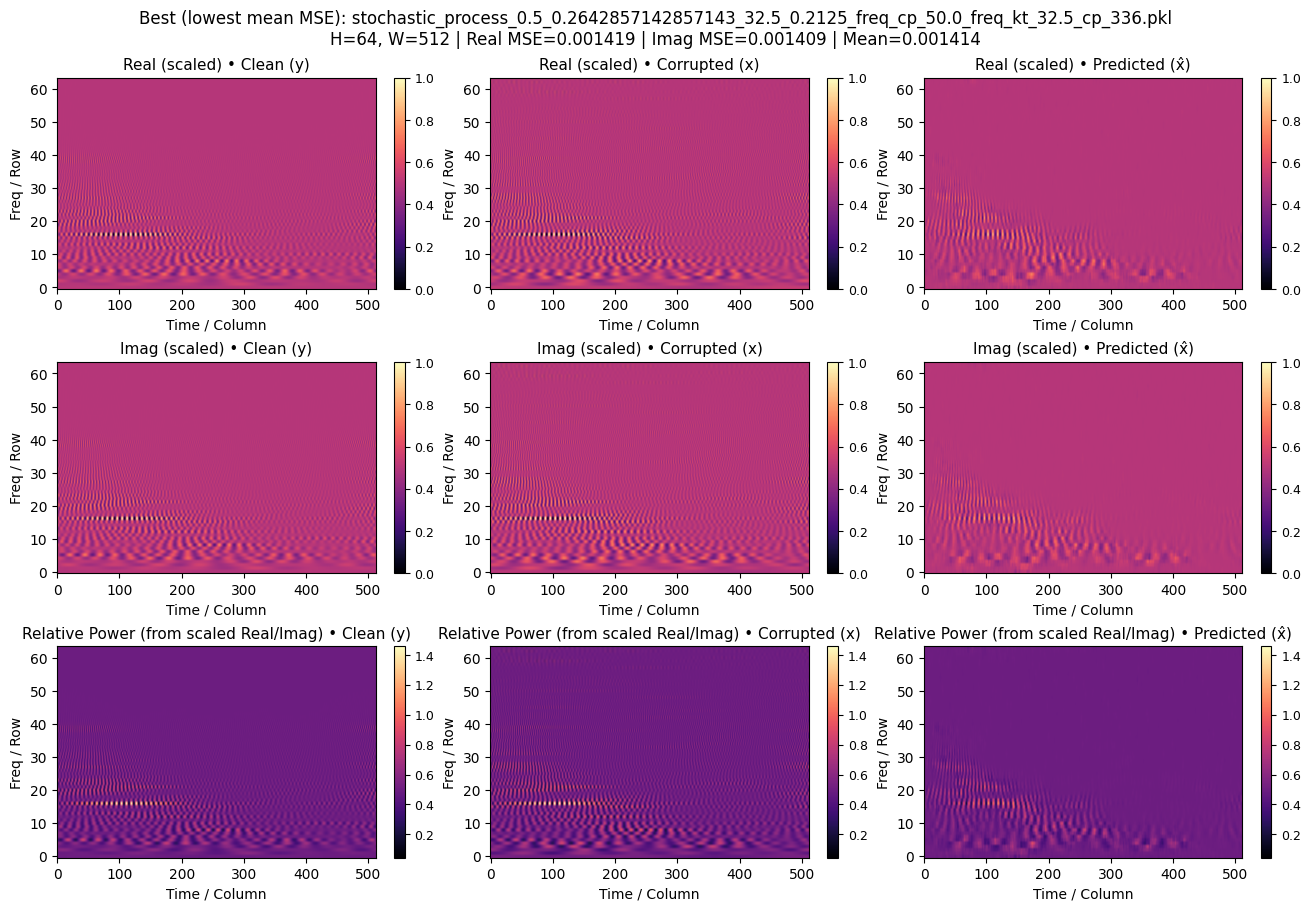

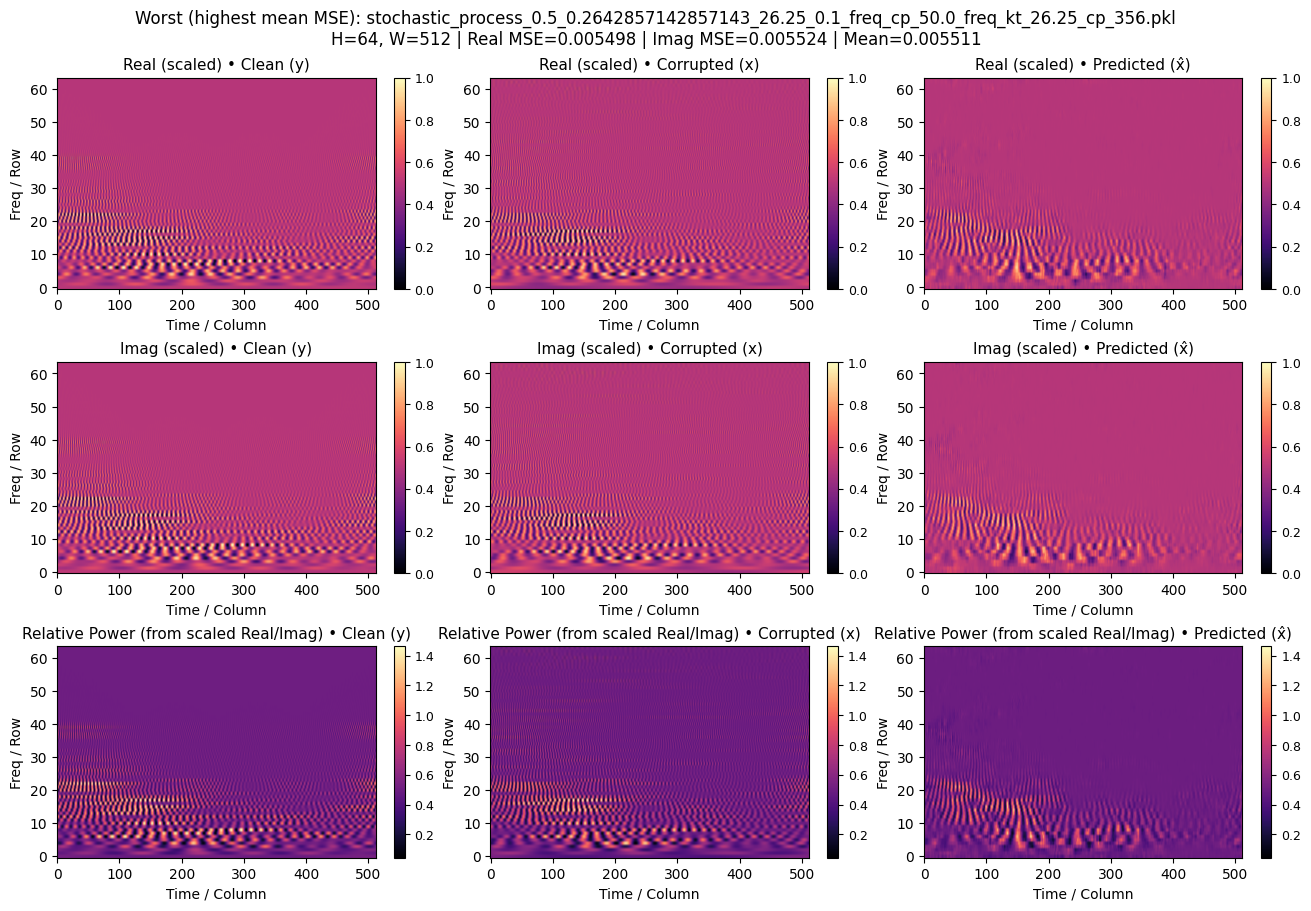

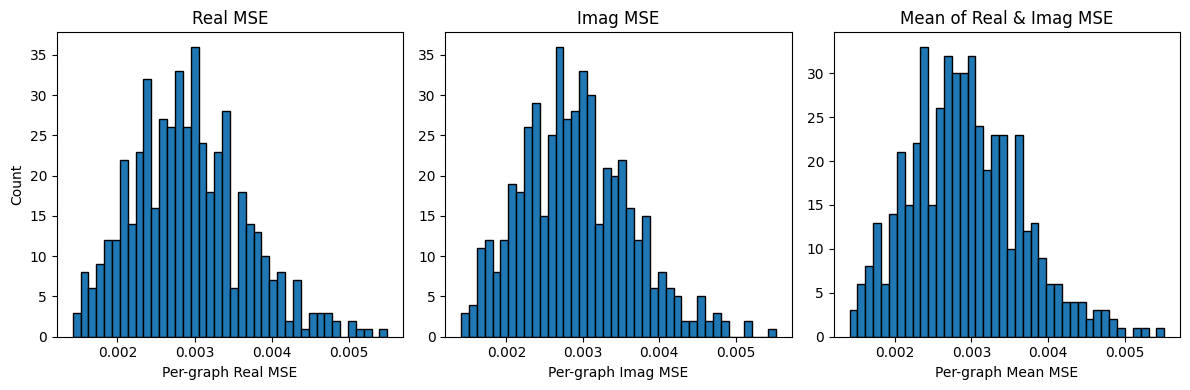

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    """
    Simple GCN stack for node-level tasks.
    - num_layers = depth
    - hidden_channels is an int (same at each layer)
    """
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int,
                 num_layers: int = 3, dropout: float = 0.2):
        super().__init__()
        assert num_layers >= 2, "Use at least 2 layers (input->hidden, hidden->output)."

        self.convs = nn.ModuleList()
        self.bns   = nn.ModuleList()
        self.dropout = dropout

        # Input layer
        self.convs.append(GCNConv(in_channels, hidden_channels, cached=False, normalize=True))
        self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels, cached=False, normalize=True))
            self.bns.append(nn.BatchNorm1d(hidden_channels))

        # Output layer
        self.convs.append(GCNConv(hidden_channels, out_channels, cached=False, normalize=True))

    def forward(self, x, edge_index, edge_weight=None):
        # All but last layer: conv -> BN -> ReLU -> Dropout
        for conv, bn in zip(self.convs[:-1], self.bns):
            x = conv(x, edge_index, edge_weight=edge_weight)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        # Last layer (no activation for regression)
        x = self.convs[-1](x, edge_index, edge_weight=edge_weight)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample = next(iter(train_loader))
in_channels  = sample.x.size(-1)
out_channels = sample.y.size(-1)
print(sample)
del sample

hidden_channels = 256
depth           = 4
pool_ratios     = 0.5

# model = GraphUNet(
#     in_channels=in_channels,
#     hidden_channels=hidden_channels,
#     out_channels=out_channels,
#     depth=depth,
#     pool_ratios=pool_ratios
# ).to(device)

model = GCN(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=depth,
    dropout=0.3
).to(device)

# 2) Load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("graphunet.pt", map_location=device))
model.to(device)
model.eval()

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# ------------------------------
# Helpers
# ------------------------------
def unflat_to_hw2(arr_flat: np.ndarray, H: int, W: int) -> np.ndarray:
    """(N, 2) -> (H, W, 2) with N=H*W, channels=[Real, Imag]."""
    return arr_flat.reshape(H, W, 2)

def _unscale_channel(arr01: np.ndarray, vmin: float, vmax: float) -> np.ndarray:
    """Invert per-channel min–max: arr = arr01*(vmax-vmin) + vmin."""
    return arr01 * (vmax - vmin) + vmin

def compute_power_maps(hw2: np.ndarray, width: int = 4, scalers: dict | None = None):
    """
    hw2: (H, W, 2) with channels [Real, Imag] (scaled to [0,1] in your pipeline).
    If `scalers` is provided with keys {'real_min','real_max','imag_min','imag_max'},
    we unscale and compute physical power = (real^2 + imag^2)/(2*pi*width).
    Otherwise, we compute relative power = (real^2 + imag^2) from the scaled inputs.
    Returns: power_map (H, W), label_suffix (str)
    """
    real = hw2[..., 0].astype(np.float64)
    imag = hw2[..., 1].astype(np.float64)

    if scalers is not None and all(k in scalers for k in ("real_min","real_max","imag_min","imag_max")):
        real = _unscale_channel(real, scalers["real_min"], scalers["real_max"])
        imag = _unscale_channel(imag, scalers["imag_min"], scalers["imag_max"])
        power = (real**2 + imag**2) / (2.0 * np.pi * float(width))
        label = f"Power |C|²/(2π·{width})"
    else:
        # relative (since real/imag were min–max scaled separately)
        power = (real**2 + imag**2)
        label = "Relative Power (from scaled Real/Imag)"
    return power, label

# ------------------------------
# Plot: Real, Imag, and Power heatmaps
# ------------------------------
def plot_heatmaps_real_imag_power(
    y_hw2, x_hw2, xhat_hw2, title_suffix="", use_fixed_scale=False, width=4,
    scalers_y=None, scalers_x=None, scalers_xhat=None
):
    """
    y_hw2, x_hw2, xhat_hw2: (H, W, 2) arrays [Real, Imag] (scaled).
    Plots 3 rows: Real, Imag, Power  ×  3 cols: Clean y, Corrupted x, Predicted x̂.

    If `scalers_*` are provided (dicts with real_min/real_max/imag_min/imag_max),
    power is physical; otherwise shown as 'Relative Power'.
    """
    # Split channels
    y_real, x_real, xhat_real = y_hw2[...,0], x_hw2[...,0], xhat_hw2[...,0]
    y_imag, x_imag, xhat_imag = y_hw2[...,1], x_hw2[...,1], xhat_hw2[...,1]

    # Power maps
    y_pow, pow_label = compute_power_maps(y_hw2, width=width, scalers=scalers_y)
    x_pow, _         = compute_power_maps(x_hw2, width=width, scalers=scalers_x)
    xhat_pow, _      = compute_power_maps(xhat_hw2, width=width, scalers=scalers_xhat)

    parts = ["Real (scaled)", "Imag (scaled)", pow_label]
    triplets = [
        (y_real, x_real, xhat_real),
        (y_imag, x_imag, xhat_imag),
        (y_pow,  x_pow,  xhat_pow),
    ]

    fig, axes = plt.subplots(3, 3, figsize=(13, 9), constrained_layout=True)
    for r in range(3):
        titles = [
            f"{parts[r]} • Clean (y)",
            f"{parts[r]} • Corrupted (x)",
            f"{parts[r]} • Predicted (x̂)",
        ]

        vmin = vmax = None
        if use_fixed_scale:
            vmin = triplets[r][0].min()
            vmax = triplets[r][0].max()

        for c in range(3):
            im = axes[r, c].imshow(
                triplets[r][c], origin="lower",
                vmin=vmin, vmax=vmax, aspect="auto"
            )
            axes[r, c].set_title(titles[c], fontsize=11)
            axes[r, c].set_xlabel("Time / Column")
            axes[r, c].set_ylabel("Freq / Row")
            cb = fig.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)
            cb.ax.tick_params(labelsize=9)

    if title_suffix:
        fig.suptitle(title_suffix, fontsize=12)
    plt.show()

# ------------------------------
# Metrics (same as before, for Real/Imag)
# ------------------------------
def per_graph_scores_real_imag(pred: torch.Tensor, target: torch.Tensor, start: int, end: int):
    P = pred[start:end]; T = target[start:end]
    real_mse = torch.mean((P[:,0] - T[:,0])**2)
    imag_mse = torch.mean((P[:,1] - T[:,1])**2)
    combined = 0.5*(real_mse + imag_mse)
    return real_mse.item(), imag_mse.item(), combined.item()

# ------------------------------
# 1) Predict on validation & collect scores
# ------------------------------
all_graph_score = []
all_graph_real_mse = []
all_graph_imag_mse = []
all_graph_meta = []

with torch.no_grad():
    for batch in val_loader:
        batch: Batch = batch.to(device, non_blocking=True)

        # Model outputs [N, 2] = [Real, Imag]
        x_hat = model(batch.x, batch.edge_index)

        ptr = batch.ptr.cpu().numpy()
        heights = batch.height.cpu().numpy()
        widths  = batch.width.cpu().numpy()
        files   = batch.file

        for i in range(len(ptr) - 1):
            s, e = int(ptr[i]), int(ptr[i+1])

            r_mse, i_mse, combo = per_graph_scores_real_imag(x_hat, batch.y, s, e)
            all_graph_real_mse.append(r_mse)
            all_graph_imag_mse.append(i_mse)
            all_graph_score.append(combo)

            # If you later add per-graph scalers to Data objects, stash them here:
            # (e.g., batch.real_min[i].item(), etc.). For now we store None.
            all_graph_meta.append({
                "file": files[i],
                "H": int(heights[i]),
                "W": int(widths[i]),
                "x_np":    batch.x[s:e].detach().cpu().numpy(),    # (M,2)
                "y_np":    batch.y[s:e].detach().cpu().numpy(),    # (M,2)
                "xhat_np": x_hat[s:e].detach().cpu().numpy(),      # (M,2)
                "scalers_y":   None,  # optionally: {"real_min":..., "real_max":..., "imag_min":..., "imag_max":...}
                "scalers_x":   None,
                "scalers_xhat":None,
            })

# ------------------------------
# 2) Plot heatmaps (best/median/worst by combined score)
# ------------------------------
order = np.argsort(all_graph_score)
idx_best   = int(order[0])
idx_median = int(order[len(order)//2])
idx_worst  = int(order[-1])

def plot_graph_at(index, tag, use_fixed_scale=False, width=4):
    meta = all_graph_meta[index]
    H, W, file = meta["H"], meta["W"], meta["file"]

    x_hw2    = unflat_to_hw2(meta["x_np"],    H, W)
    y_hw2    = unflat_to_hw2(meta["y_np"],    H, W)
    xhat_hw2 = unflat_to_hw2(meta["xhat_np"], H, W)

    title = (f"{tag}: {file}\n"
             f"H={H}, W={W} | "
             f"Real MSE={all_graph_real_mse[index]:.6f} | "
             f"Imag MSE={all_graph_imag_mse[index]:.6f} | "
             f"Mean={all_graph_score[index]:.6f}")

    plot_heatmaps_real_imag_power(
        y_hw2, x_hw2, xhat_hw2,
        title_suffix=title,
        use_fixed_scale=use_fixed_scale,
        width=width,
        scalers_y=meta.get("scalers_y"),
        scalers_x=meta.get("scalers_x"),
        scalers_xhat=meta.get("scalers_xhat"),
    )

# Examples
plot_graph_at(idx_best,   "Best (lowest mean MSE)",  use_fixed_scale=True, width=4)
plot_graph_at(idx_median, "Median (mean MSE)",       use_fixed_scale=True, width=4)
plot_graph_at(idx_worst,  "Worst (highest mean MSE)",use_fixed_scale=True, width=4)

# ------------------------------
# 3) Histograms (unchanged)
# ------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(all_graph_real_mse, bins=40, edgecolor="black")
plt.xlabel("Per-graph Real MSE"); plt.ylabel("Count"); plt.title("Real MSE")

plt.subplot(1,3,2)
plt.hist(all_graph_imag_mse, bins=40, edgecolor="black")
plt.xlabel("Per-graph Imag MSE"); plt.title("Imag MSE")

plt.subplot(1,3,3)
plt.hist(all_graph_score, bins=40, edgecolor="black")
plt.xlabel("Per-graph Mean MSE"); plt.title("Mean of Real & Imag MSE")

plt.tight_layout()
plt.show()

# Diffusion model [not good]

## Train

In [6]:
import os, time, random
import torch
import torch.nn.functional as F
from diffusers import UNet2DModel, DDPMScheduler

# ↓ Optional: reduces fragmentation for tight VRAM
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

seed = 42
random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---- Model: lighter U-Net, keep attention at bottleneck ----
unet = UNet2DModel(
    sample_size=(64, 512),
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128, 128),
    down_block_types=("AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D"),
)

# Gradient checkpointing (big memory saver)
unet.enable_gradient_checkpointing()

unet.to(device)
unet.to(memory_format=torch.channels_last)

# ---- Scheduler (DDPM) ----
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-4, beta_end=0.02,
    beta_schedule="linear",
    prediction_type="epsilon",
)

# ---- Optimizer ----
optimizer = torch.optim.AdamW(unet.parameters(), lr=2e-4, weight_decay=1e-4)

# ---- Mixed precision (new API) ----
use_amp = torch.cuda.is_available()
scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

# ---- Training config ----
epochs = 40
grad_accum_steps = 2          # simulate larger batch
log_every = 100
ckpt_dir = "eps_ddpm_ckpts_mem"
os.makedirs(ckpt_dir, exist_ok=True)

def cast_channels_last(x):
    return x.to(memory_format=torch.channels_last)

def train_one_epoch(epoch):
    unet.train()
    running = 0.0
    n_steps = 0
    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(train_loader):
        clean = batch.to(device, non_blocking=True)
        clean = cast_channels_last(clean)

        bsz = clean.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (bsz,), device=device, dtype=torch.long
        )
        noise = torch.randn_like(clean)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
            noisy = noise_scheduler.add_noise(clean, noise, timesteps)
            pred = unet(noisy, timesteps).sample
            loss = F.mse_loss(pred, noise)

        scaler.scale(loss / grad_accum_steps).backward()

        if (step + 1) % grad_accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        running += loss.item()
        n_steps += 1

        if (step + 1) % log_every == 0:
            print(f"[Epoch {epoch:03d} | Step {step+1:05d}] loss={running/n_steps:.4f}")

    return running / max(n_steps, 1)

@torch.no_grad()
def evaluate(n_batches=10):
    unet.eval()
    tot = 0.0
    n = 0
    it = iter(val_loader)
    for _ in range(n_batches):
        try:
            batch = next(it)
        except StopIteration:
            break
        clean = batch.to(device, non_blocking=True)
        clean = cast_channels_last(clean)
        bsz = clean.shape[0]
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device, dtype=torch.long)
        noise = torch.randn_like(clean)
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
            noisy = noise_scheduler.add_noise(clean, noise, timesteps)
            pred = unet(noisy, timesteps).sample
            loss = F.mse_loss(pred, noise)
        tot += loss.item()
        n += 1
    return tot / max(n, 1)

best_val = float("inf")
for ep in range(1, epochs + 1):
    t0 = time.time()
    tr_loss = train_one_epoch(ep)
    val_loss = evaluate(n_batches=10)
    dt = time.time() - t0
    print(f"Epoch {ep:03d} | train={tr_loss:.4f} | val={val_loss:.4f} | {dt:.1f}s")

    if val_loss < best_val:
        best_val = val_loss
        save_dir = os.path.join(ckpt_dir, "best")
        unet.save_pretrained(save_dir)
        noise_scheduler.save_pretrained(save_dir)
        print(f"  ↳ Saved best to {save_dir} (val={best_val:.4f})")

final_dir = os.path.join(ckpt_dir, "final")
unet.save_pretrained(final_dir)
noise_scheduler.save_pretrained(final_dir)
print("Saved final checkpoint to", final_dir)

/home/jgduarte/Documents/RA/stochastic_dynamics/diffusion_model_stochastic_process/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
[Epoch 001 | Step 00100] loss=0.1939
[Epoch 001 | Step 00200] loss=0.1251
[Epoch 001 | Step 00300] loss=0.0962
[Epoch 001 | Step 00400] loss=0.0796
[Epoch 001 | Step 00500] loss=0.0685
[Epoch 001 | Step 00600] loss=0.0604
[Epoch 001 | Step 00700] loss=0.0543
[Epoch 001 | Step 00800] loss=0.0499
[Epoch 001 | Step 00900] loss=0.0463
[Epoch 001 | Step 01000] loss=0.0431
[Epoch 001 | Step 01100] loss=0.0403
[Epoch 001 | Step 01200] loss=0.0381
[Epoch 001 | Step 01300] loss=0.0361
[Epoch 001 | Step 01400] loss=0.0344
[Epoch 001 | Step 01500] loss=0.0328
[Epoch 001 | Step 01600] loss=0.0315
[Epoch 001 | Step 01700] loss=0.0302
[Epoch 001 | Step 01800] loss=0.0291
[Epoch 001 | Step 01900] loss=0.0280
[Epoch 001 | Step 02000] loss=0.0271
[Epoch 001 | Step 02100] loss=0.0263
[Epoch 001 | Step 02200] loss=0.0255
Epoch 001 | train=0.0251 | val=0.0109 | 9747.8s
  ↳ Saved best to eps_ddpm_ckpts_mem/best (val=0.0109)
[Epoch 002 | Step 00100] loss=0.0088
[Epoch 002 | Step 00200] loss=0.0

KeyboardInterrupt: 

## Inference

/home/jgduarte/Documents/RA/stochastic_dynamics/diffusion_model_stochastic_process/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jgduarte/Documents/RA/stochastic_dynamics/diffusion_model_stochastic_process/.venv/lib/python3.13/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `clip_sample` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'clip_sample' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.clip_sample'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Diffusers UNet lacks set_attn_processor; skipping SDPA fast attention.


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


z_cal range: -1.128645658493042 6.482795715332031
eps   range: 0.0 0.45599931478500366


100%|██████████| 100/100 [09:54<00:00,  5.95s/it]


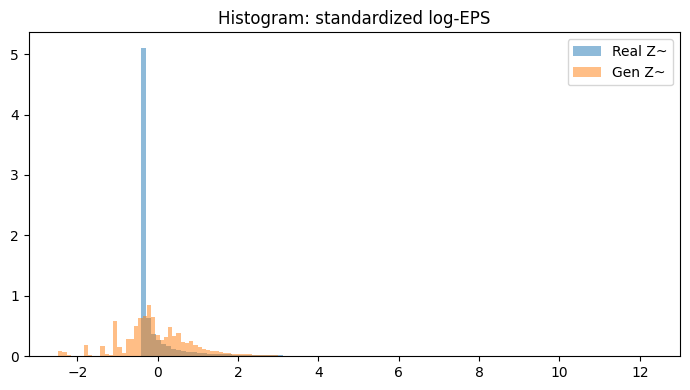

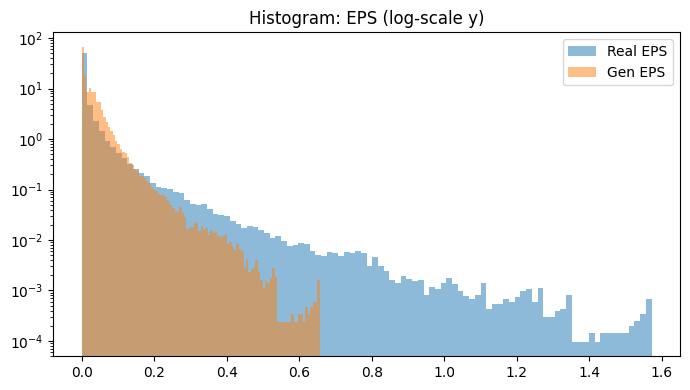

100%|██████████| 100/100 [09:54<00:00,  5.95s/it]


100%|██████████| 100/100 [09:54<00:00,  5.95s/it]


Wasserstein distance (EPS): 0.012502
KS test statistic: 0.3316, p-value: 0.000e+00


In [4]:
# ============================================
# Inference: load, fast settings, sample, eval
# ============================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from diffusers import UNet2DModel, DDPMScheduler

# ----------------- CONFIG -----------------
ckpt_dir = "eps_ddpm_ckpts_mem/best"  # your checkpoint dir
device   = "cuda" if torch.cuda.is_available() else "cpu"

# normalization params from training
alpha = 5.0
mu    = 0.07396781351831225
sigma = 0.17182008262835613

# ----------------- LOAD -------------------
unet = UNet2DModel.from_pretrained(ckpt_dir).to(device).eval()

# DDPM scheduler with NO CLIPPING
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=1e-4, beta_end=0.02, beta_schedule="linear",
    prediction_type="epsilon",
    clip_sample=False,
)
# (defensive) also ensure attribute off if present
if hasattr(noise_scheduler, "clip_sample"):
    noise_scheduler.clip_sample = False

# ----------------- PERF TOGGLES -----------
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")   # TF32 on Ampere
torch.backends.cuda.matmul.allow_tf32 = True

# (inference) disable grad checkpointing if enabled during training
try:
    unet.disable_gradient_checkpointing()
except AttributeError:
    pass

# ---- (SAFE) attention speed-up: only if your diffusers version supports it ----
try:
    from diffusers.models.attention_processor import AttnProcessor2_0
    if hasattr(unet, "set_attn_processor"):
        unet.set_attn_processor(AttnProcessor2_0())
        print("Enabled SDPA attention via AttnProcessor2_0.")
    else:
        print("Diffusers UNet lacks set_attn_processor; skipping SDPA fast attention.")
except Exception as e:
    print("Could not enable SDPA attention:", repr(e))

# ----------------- HELPERS ----------------
@torch.inference_mode()
def inverse_standardize_to_eps(z_tilde: torch.Tensor, mu: float, sigma: float, alpha: float) -> torch.Tensor:
    """
    z_tilde: (..., 64, 512) standardized log-EPS
    returns: EPS >= 0 with same trailing shape
    """
    Z = sigma * z_tilde + mu
    X = torch.expm1(Z) / alpha
    return torch.clamp(X, min=0.0)

@torch.inference_mode()
def ddpm_sample_raw(
    unet: UNet2DModel,
    scheduler: DDPMScheduler,
    n: int = 4,
    steps: int = 50,
    device: str = "cuda",
    show_progress: bool = True,
) -> torch.Tensor:
    """
    Manual DDPM sampling (no pipeline post-processing / clamping).
    Returns z_tilde in training domain, shape (n,1,64,512), torch.float32 (CPU).
    """
    scheduler.set_timesteps(steps, device=device)
    x = torch.randn((n, 1, 64, 512), device=device)
    autocast_on = device.startswith("cuda") and torch.cuda.is_available()

    it = scheduler.timesteps
    it = tqdm(it) if show_progress else it
    for t in it:
        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=autocast_on):
            eps_pred = unet(x, t).sample
        x = scheduler.step(eps_pred, t, x).prev_sample

    return x.float().cpu()

@torch.inference_mode()
def self_calibrate(z: torch.Tensor) -> torch.Tensor:
    """
    Per-batch normalization in standardized domain to fix global amplitude bias.
    Keeps inference fast (no extra sampling).
    """
    m = z.mean()
    s = z.std(unbiased=False)
    return (z - m) / (s + 1e-8)

@torch.inference_mode()
def sample_ztilde(n: int = 4, steps: int = 50, show_progress: bool = True) -> torch.Tensor:
    """
    Wrapper that samples and applies per-batch self-calibration.
    Returns (n,1,64,512) standardized log-EPS on CPU.
    """
    z = ddpm_sample_raw(unet, noise_scheduler, n=n, steps=steps, device=device, show_progress=show_progress)
    z = self_calibrate(z)   # <-- one-line amplitude fix; comment out if you don't want it
    return z

# --------------- VISUALIZATION ------------
@torch.inference_mode()
def sample_and_plot(n: int = 4, steps: int = 50, show_progress: bool = True):
    z_cal = sample_ztilde(n=n, steps=steps, show_progress=show_progress)  # (n,1,64,512)
    eps   = inverse_standardize_to_eps(z_cal, mu, sigma, alpha)

    print("z_cal range:", float(z_cal.min()), float(z_cal.max()))
    print("eps   range:", float(eps.min()),   float(eps.max()))

    B = z_cal.shape[0]
    fig, axs = plt.subplots(2, B, figsize=(3.6*B, 6))
    if B == 1: axs = np.expand_dims(axs, 1)
    for i in range(B):
        im0 = axs[0, i].imshow(z_cal[i,0], origin="lower", aspect="auto")
        axs[0, i].set_title(f"Z~ (cal) #{i}"); axs[0, i].axis("off"); plt.colorbar(im0, ax=axs[0,i], fraction=0.046, pad=0.04)
        im1 = axs[1, i].imshow(eps[i,0],  origin="lower", aspect="auto")
        axs[1, i].set_title(f"EPS #{i}");     axs[1, i].axis("off"); plt.colorbar(im1, ax=axs[1,i], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# --------- DISTRIBUTION-LEVEL CHECKS -----
try:
    from scipy.stats import wasserstein_distance, ks_2samp
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

@torch.inference_mode()
def value_histograms(real_loader, n_gen=200, steps=50, bins=100, show_progress: bool = True):
    # collect ~n_gen real standardized log-EPS
    real_batches, cnt = [], 0
    for xb in real_loader:
        real_batches.append(xb)
        cnt += xb.shape[0]
        if cnt >= n_gen: break
    if len(real_batches) == 0:
        raise RuntimeError("real_loader yielded no batches.")
    real_z = torch.cat(real_batches, dim=0)[:n_gen]           # (n_gen,1,64,512)

    gen_z = sample_ztilde(n=n_gen, steps=steps, show_progress=show_progress)  # (n_gen,1,64,512)

    # standardized domain
    rvals = real_z.cpu().numpy().ravel()
    gvals = gen_z.cpu().numpy().ravel()
    plt.figure(figsize=(7,4))
    plt.hist(rvals, bins=bins, alpha=0.5, label="Real Z~", density=True)
    plt.hist(gvals, bins=bins, alpha=0.5, label="Gen Z~",  density=True)
    plt.legend(); plt.title("Histogram: standardized log-EPS"); plt.tight_layout(); plt.show()

    # EPS domain
    real_eps = inverse_standardize_to_eps(real_z, mu, sigma, alpha).cpu().numpy().ravel()
    gen_eps  = inverse_standardize_to_eps(gen_z,  mu, sigma, alpha).cpu().numpy().ravel()
    plt.figure(figsize=(7,4))
    plt.hist(real_eps, bins=bins, alpha=0.5, label="Real EPS", density=True, log=True)
    plt.hist(gen_eps,  bins=bins, alpha=0.5, label="Gen EPS",  density=True, log=True)
    plt.legend(); plt.title("Histogram: EPS (log-scale y)"); plt.tight_layout(); plt.show()

@torch.inference_mode()
def marginals(real_loader, n_gen=200, steps=50, show_progress: bool = True):
    real_batches, cnt = [], 0
    for xb in real_loader:
        real_batches.append(xb)
        cnt += xb.shape[0]
        if cnt >= n_gen: break
    if len(real_batches) == 0:
        raise RuntimeError("real_loader yielded no batches.")
    real_z = torch.cat(real_batches, dim=0)[:n_gen]
    gen_z  = sample_ztilde(n=n_gen, steps=steps, show_progress=show_progress)

    real_eps = inverse_standardize_to_eps(real_z, mu, sigma, alpha)
    gen_eps  = inverse_standardize_to_eps(gen_z,  mu, sigma, alpha)

    # frequency marginal (mean over time)
    f_real = real_eps.mean(dim=[0,3])[0].cpu().numpy()   # (64,)
    f_gen  = gen_eps.mean(dim=[0,3])[0].cpu().numpy()
    # time marginal (mean over freq)
    t_real = real_eps.mean(dim=[0,2])[0].cpu().numpy()   # (512,)
    t_gen  = gen_eps.mean(dim=[0,2])[0].cpu().numpy()

    fig, axs = plt.subplots(1,2, figsize=(12,4))
    axs[0].plot(f_real, label="Real"); axs[0].plot(f_gen, label="Gen")
    axs[0].set_title("Frequency marginal (mean over time)"); axs[0].legend()
    axs[1].plot(t_real, label="Real"); axs[1].plot(t_gen, label="Gen")
    axs[1].set_title("Time marginal (mean over freq)"); axs[1].legend()
    plt.tight_layout(); plt.show()

@torch.inference_mode()
def distribution_distances(real_loader, n_gen=500, steps=50, show_progress: bool = True):
    if not _HAS_SCIPY:
        print("SciPy not available (pip install scipy) — skipping distances.")
        return
    real_batches, cnt = [], 0
    for xb in real_loader:
        real_batches.append(xb)
        cnt += xb.shape[0]
        if cnt >= n_gen: break
    if len(real_batches) == 0:
        raise RuntimeError("real_loader yielded no batches.")
    real_z = torch.cat(real_batches, dim=0)[:n_gen]
    gen_z  = sample_ztilde(n=n_gen, steps=steps, show_progress=show_progress)

    real_eps = inverse_standardize_to_eps(real_z, mu, sigma, alpha).cpu().numpy().ravel()
    gen_eps  = inverse_standardize_to_eps(gen_z,  mu, sigma, alpha).cpu().numpy().ravel()

    wd = wasserstein_distance(real_eps, gen_eps)
    ks = ks_2samp(real_eps, gen_eps)
    print(f"Wasserstein distance (EPS): {wd:.6f}")
    print(f"KS test statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.3e}")

# --------- SIDE-BY-SIDE (unconditional) ----
@torch.inference_mode()
def compare_real_vs_generated(loader, n: int = 4, steps: int = 50, show_progress: bool = True):
    # real batch
    it = iter(loader)
    try:
        real = next(it)[:n].to(device)
    except StopIteration:
        raise RuntimeError("loader yielded no batches.")
    # generated (standardized, calibrated)
    gen  = sample_ztilde(n=n, steps=steps, show_progress=show_progress).to(device)

    real_eps = inverse_standardize_to_eps(real, mu, sigma, alpha)
    gen_eps  = inverse_standardize_to_eps(gen,  mu, sigma, alpha)

    # simple metrics (note: unconditional — not 1:1 matches)
    mse_std = ((real - gen)**2).flatten(1).mean(dim=1).cpu().numpy()
    mae_std = (real - gen).abs().flatten(1).mean(dim=1).cpu().numpy()
    mse_eps = ((real_eps - gen_eps)**2).flatten(1).mean(dim=1).cpu().numpy()
    mae_eps = (real_eps - gen_eps).abs().flatten(1).mean(dim=1).cpu().numpy()
    for i in range(len(mse_std)):
        print(f"#{i:02d}  MSE_std={mse_std[i]:.4e}  MAE_std={mae_std[i]:.4e}   "
              f"MSE_eps={mse_eps[i]:.4e}  MAE_eps={mae_eps[i]:.4e}")

    # visualize Z~ and EPS with diffs
    real_cpu, gen_cpu = real.cpu(), gen.cpu()
    diff = gen_cpu - real_cpu
    B = real_cpu.shape[0]
    fig, axs = plt.subplots(3, B, figsize=(3.6*B, 8))
    if B == 1: axs = np.expand_dims(axs, 1)
    for i in range(B):
        im0 = axs[0, i].imshow(real_cpu[i,0], origin="lower", aspect="auto"); axs[0,i].set_title(f"Real Z~ #{i}")
        axs[0, i].axis("off"); plt.colorbar(im0, ax=axs[0,i], fraction=0.046, pad=0.04)
        im1 = axs[1, i].imshow(gen_cpu[i,0],  origin="lower", aspect="auto"); axs[1,i].set_title(f"Gen Z~ #{i}")
        axs[1, i].axis("off"); plt.colorbar(im1, ax=axs[1,i], fraction=0.046, pad=0.04)
        im2 = axs[2, i].imshow(diff[i,0],     origin="lower", aspect="auto"); axs[2,i].set_title(f"Diff Z~ #{i}")
        axs[2, i].axis("off"); plt.colorbar(im2, ax=axs[2,i], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    real_eps, gen_eps = real_eps.cpu(), gen_eps.cpu()
    diff_eps = gen_eps - real_eps
    fig, axs = plt.subplots(3, B, figsize=(3.6*B, 8))
    if B == 1: axs = np.expand_dims(axs, 1)
    for i in range(B):
        im0 = axs[0, i].imshow(real_eps[i,0], origin="lower", aspect="auto"); axs[0,i].set_title(f"Real EPS #{i}")
        axs[0, i].axis("off"); plt.colorbar(im0, ax=axs[0,i], fraction=0.046, pad=0.04)
        im1 = axs[1, i].imshow(gen_eps[i,0],  origin="lower", aspect="auto"); axs[1,i].set_title(f"Gen EPS #{i}")
        axs[1, i].axis("off"); plt.colorbar(im1, ax=axs[1,i], fraction=0.046, pad=0.04)
        im2 = axs[2, i].imshow(diff_eps[i,0], origin="lower", aspect="auto"); axs[2,i].set_title(f"Diff EPS #{i}")
        axs[2, i].axis("off"); plt.colorbar(im2, ax=axs[2,i], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# ----------------- EXAMPLES ----------------
# Quick visual check (progress bar off for speed):
sample_and_plot(n=4, steps=100, show_progress=True)

# Distribution checks (keep n_gen small for speed; steps=50 as you asked)
value_histograms(train_loader, n_gen=40, steps=100, show_progress=True)
marginals(train_loader, n_gen=40, steps=100, show_progress=True)
distribution_distances(train_loader, n_gen=40, steps=100, show_progress=True)

# Side-by-side (unconditional)
# compare_real_vs_generated(train_loader, n=4, steps=50, show_progress=False)

# Latent Diffusion Model